In [186]:
import os
import requests
import pandas as pd
import numpy as np
import time
import datetime
from pathlib import Path
from panel.interact import interact
import plotly.express as px
import panel as pn
import hvplot.pandas

In [187]:
# Read data from csv
crypto_history_data = Path("data/data_5year.csv")
sp500_history_data = Path("data/sp500_closes.csv")

crypto_history_df = pd.read_csv(crypto_history_data)
sp500_history_df = pd.read_csv(sp500_history_data)

# clean unused column from crypto dataframe
if 'Unnamed: 0' in crypto_history_df.columns:
    crypto_history_df = crypto_history_df.drop(['Unnamed: 0'], axis=1)
    
# Create column 'Ticker' in SP500 dataframe with value "S&P 500"
if not 'Ticker' in sp500_history_df.columns:
    sp500_history_df.insert(loc=0, column='Ticker', value="S&P 500")
    
# Remove ' hour:minute:second' from "date" column
sp500_history_df["Date"] = sp500_history_df["Date"].replace({'\s\d{2}:\d{2}:\d{2}' : ''}, regex=True)

# Ensure Date columns are formatted properly
crypto_history_df["Date"] = pd.to_datetime(crypto_history_df["Date"])
sp500_history_df["Date"] = pd.to_datetime(sp500_history_df["Date"])

# Rename 'Close' column to 'Price' in s&P 500 dataframe
sp500_history_df = sp500_history_df.rename(columns={"Close": "Price"})

In [207]:
# Define Functions

def pivot_price_dataframe(history_df, ticker_list, ticker_header=None, price_header=None):
    
    price_df = None
    unwanted_tickers = []
    
    try:
        
        # Test if ticker_header suppied exists, and looks for a default header if not
        
        if not ticker_header in list(history_df.columns):
            if "Ticker" in list(history_df.columns):
                ticker_header = "Ticker"
            elif "ticker" in list(history_df.columns):
                ticker_header = "ticker"
            else:
                 raise ValueError(f"No ticker column found")
    
        if not price_header in list(history_df.columns):
            if "Price" in list(history_df.columns):
                price_header = "Price"
            elif "price" in list(history_df.columns):
                price_header = "price"
            else:
                raise ValueError(f"No price column found")
        
        existing_tickers = history_df[ticker_header].unique()
        
        # test if valid tickers are supplied
        
        for ticker in ticker_list:
            if not ticker in list(existing_tickers):
                raise ValueError(f"Ticker \"{ticker}\" does not exist in dataframe")
    
        # Pivot
        price_df = history_df.pivot(index="Date", columns=ticker_header, values=price_header)
    
        # Drop unwanted tickers, so we're only getting those specified by ticker_list
        for ticker in list(price_df.columns):
            if not ticker in ticker_list:
                unwanted_tickers.append(ticker)
        
        price_df = price_df.drop(unwanted_tickers, axis=1)
        
        # Drop NA, and rename columns.name
        price_df = price_df.dropna()
        
        price_df.columns.name = "Price"
        
    except ValueError as err:
        print('Value error: ', err)
    
    return price_df

def daily_returns_dataframe(price_df):
    
    daily_returns = price_df.sort_index(ascending=False).pct_change().dropna()
    
    daily_returns.columns.name = "Daily Returns"
    
    return daily_returns

def cumulative_returns_dataframe(price_df):
    
    # Get daily returns
    daily_returns = daily_returns_dataframe(price_df)
    
    # Calculate cumulative returns
    cumulative_returns = (1 + daily_returns).cumprod()
    
    # Rename column to "Cumulative Returns"
    cumulative_returns.columns.name = "Cumulative Returns"
    
    return cumulative_returns

def correlation_dataframe(daily_returns_df):
    
    correlation = daily_returns_df.corr()
    
    correlation.columns.name = "Correlation"
    
    correlation.index.name = "Tickers"
    
    return correlation

def rolling_beta_dataframe(daily_returns_df, period, covariance_compare):
    
    existing_tickers = list(daily_returns_df.columns)
    
    # Check to see if our covariance comparison column exists in dataframe
    try:
        if not covariance_compare in existing_tickers:
            raise ValueError(f"Ticker \"{covariance_compare}\" does not exist in dataframe")
            
        # Ensure dates are sorted in ascending order
        daily_returns_df = daily_returns_df.sort_index(ascending=True)
            
        # Calculate rolling covariance, including covariance with our covariance comparison column
        rolling_covariance = daily_returns_df.rolling(window=period).cov(daily_returns_df[covariance_compare])
        
        # Calculate variance with our covariance comparison column
        rolling_variance = daily_returns_df[covariance_compare].rolling(window=period).var()
        
        # Drop our covariance comparison column from rolling covariance: beta = cov / var, so that column would show up as all 1
        rolling_covariance = rolling_covariance.drop([covariance_compare], axis=1)
        
        # calculate rolling beta and drop na
        rolling_beta = rolling_covariance.divide(rolling_variance, axis=0)
        rolling_beta.dropna(inplace=True)
        rolling_beta.columns.name = f"{period} Day Rolling Beta"
        
    except ValueError as err:
        print('Value error: ', err)
        
    return rolling_beta

def annualized_sharpe_ratios_dataframe(daily_returns_df, trading_days=252):
    
    sharpe_ratios_df = (daily_returns_df.mean() / daily_returns_df.std()) * np.sqrt(trading_days)
    
    return sharpe_ratios_df

def cumulative_returns_plot(cumulative_returns_df):
    
    plt = px.line(cumulative_returns_df, labels=dict(x="Date", y="Cumulative Returns", color="Cumulative Returns")) 
        
    plt.update_xaxes(title_text='Date')
    plt.update_yaxes(title_text='Cumulative Returns')
    
    return plt


def correlation_plot(correlation_df):
    
    plt = correlation_df.hvplot.heatmap()
    
    return plt

def rolling_beta_plot(rolling_beta_df, period):
    
    plt = px.line(rolling_beta_df, labels=dict(x=f"Date", y=f"{period} Day Rolling Beta", color=f"{period} Day Rolling Beta")) 
        
    plt.update_xaxes(title_text="Date")
    plt.update_yaxes(title_text=f"{period} Day Rolling Beta")
    
    return plt

def price_summary_violin(price_df):
    
    plt = px.violin(price_df)
    
    plt.update_xaxes(title_text="Ticker")
    plt.update_yaxes(title_text=f"Price Summary")
    
    return plt

def sharpe_ratios_plot(sharpe_ratios_df):

    plt = px.bar(sharpe_ratios_df)
    
    plt.update_xaxes(title_text="Ticker")
    plt.update_yaxes(title_text=f"Sharpe Ratios")
    
    plt.update_yaxes(range=[-1,1])
    
    return plt



In [200]:
# Calculate price dataframes
crypto_pivot_price_df = pivot_price_dataframe(history_df=crypto_history_df, ticker_list = list(crypto_history_df["Ticker"].unique()))
sp500_pivot_price_df = pivot_price_dataframe(history_df=sp500_history_df, ticker_list = list(sp500_history_df["Ticker"].unique()))

# Join crypto prices with S&P 500 closes
joined_price_df = pd.concat([crypto_pivot_price_df, sp500_pivot_price_df], axis=1, join = 'inner')

# Get daily returns
joined_daily_returns_df = daily_returns_dataframe(joined_price_df)

# Get cumulative returns
joined_cumulative_returns_df = cumulative_returns_dataframe(joined_price_df)

# Get correlation
joined_correlation_df = correlation_dataframe(joined_daily_returns_df)

# Get rolling beta
joined_beta_df = rolling_beta_dataframe(joined_daily_returns_df, period = 21, covariance_compare = "S&P 500")

# Get annualized sharpe ratios
joined_sharpe_ratios = annualized_sharpe_ratios_dataframe(joined_daily_returns_df)

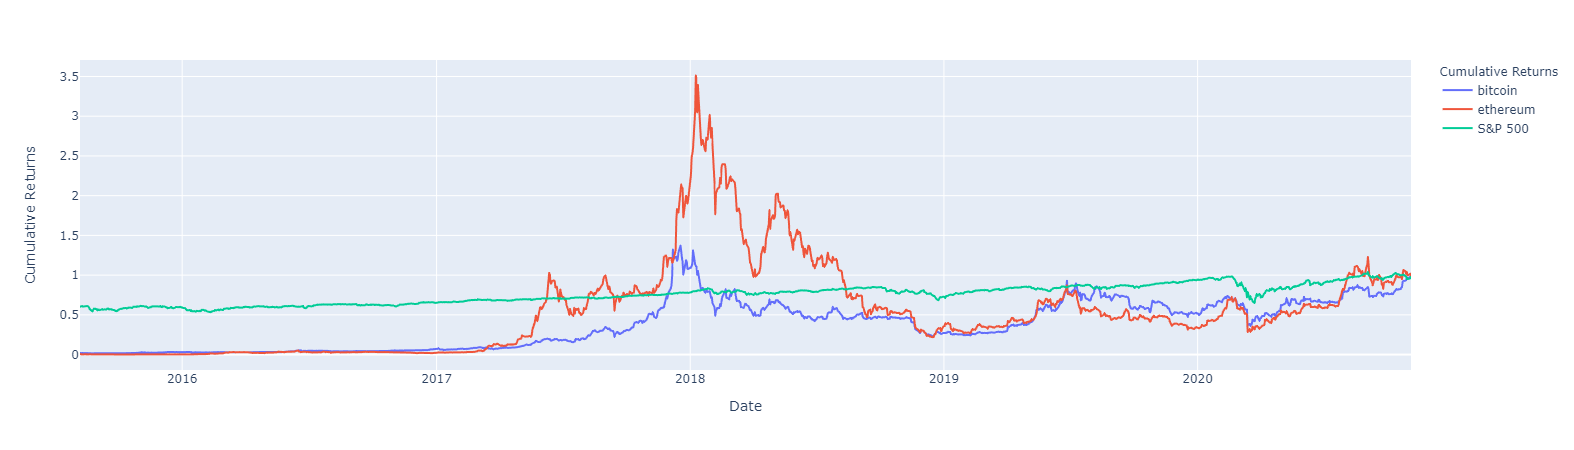

In [191]:
# Plot cumulative returns
cumulative_returns_plot(joined_cumulative_returns_df)

In [192]:
# correlation heatmap 
correlation_plot(joined_correlation_df)

:HeatMap   [columns,index]   (value)

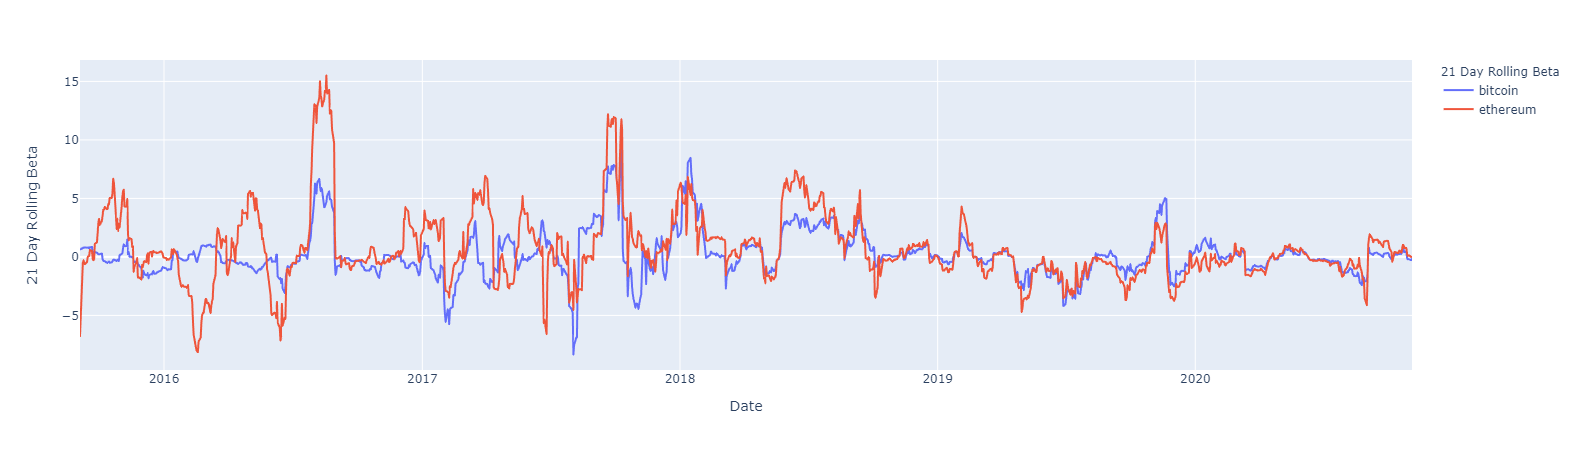

In [193]:
# rolling beta plot
rolling_beta_plot(joined_beta_df, period=21)

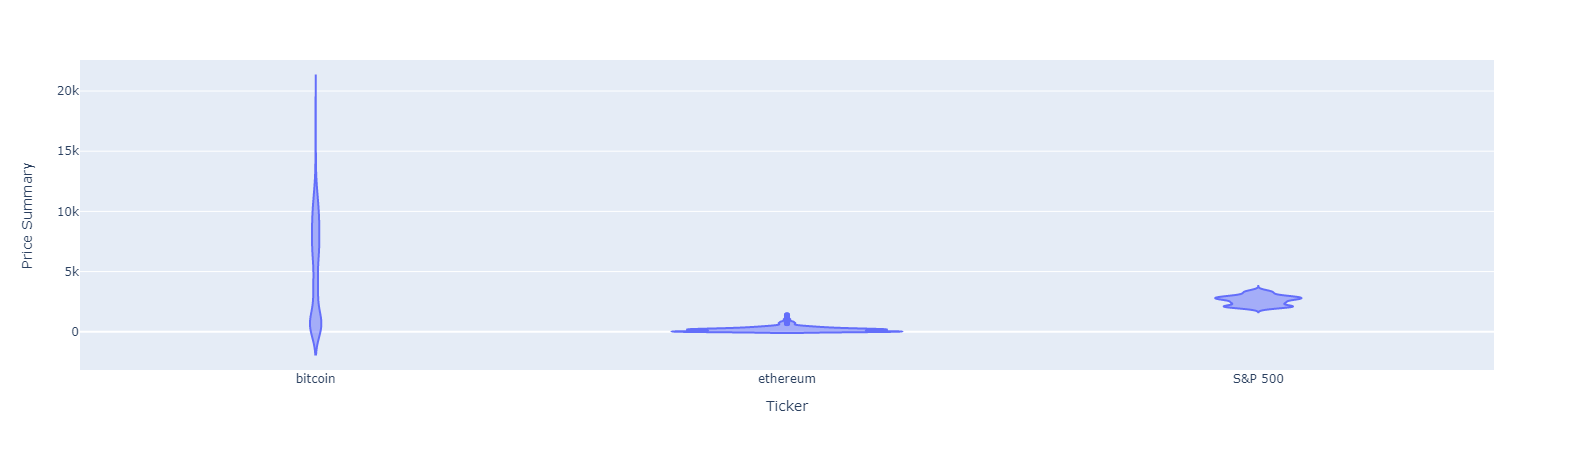

In [194]:
# Plot summary including min, max, quartiles, and median with violin plot
price_summary_violin(joined_price_df)

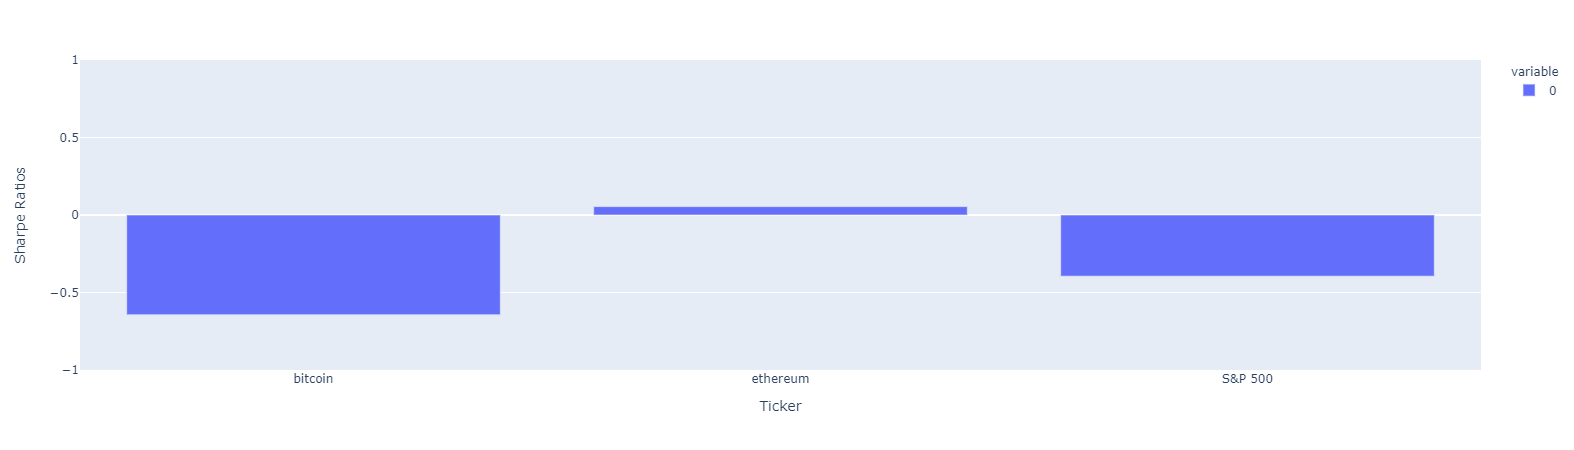

In [208]:
sharpe_ratios_plot(joined_sharpe_ratios)

Daily Returns
bitcoin    -0.001902
ethereum    0.000390
S&P 500    -0.000308
dtype: float64